Importing Libraries

In [292]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_score, recall_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE

Loading Dataset

In [293]:
file_path = r'D:\Masters\Individual Project\Breast Cancer Model Quiz applciation\new-dataset_main.csv'
data = pd.read_csv(file_path)

Displaying the first few rows of the dataset

In [294]:
print(data.head())

     age mefalsepause tumor-size inv-falsedes falsede-caps  deg-malig breast  \
0  32-35   premefalse      15-19          0-2         True        3.0  right   
1  32-35         ge40      15-19          0-2        False        1.0  right   
2  32-35         ge40      35-39          0-2        False        2.0   left   
3  32-35   premefalse      35-39          0-2         True        3.0  right   
4  32-35   premefalse      30-34          3-5         True        2.0   left   

  breast-quad irradiat                    class  
0     left_up    False        recurrence-events  
1     central    False  false-recurrence-events  
2    left_low    False        recurrence-events  
3    left_low     True  false-recurrence-events  
4    right_up    False        recurrence-events  


Handling missing values

In [295]:
data = data.dropna()

Encoding categorical variables

In [296]:
# Encode categorical variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

In [297]:
# Split the data into features and target
X = data.drop('class', axis=1)
y = data['class']

In [298]:
# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [299]:
# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)


In [300]:
# Feature Selection using RFE with Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
rfe = RFE(estimator=gb_model, n_features_to_select=10)  # Select top 10 features
X = rfe.fit_transform(X, y)

c:\Users\user\anaconda3\anaconda3new\envs\cancer\lib\site-packages\sklearn\feature_selection\_rfe.py:291: UserWarning: Found n_features_to_select=10 > n_features=9. There will be no feature selection and all features will be kept.
  warnings.warn(


In [301]:
# Logistic Regression Model for RFE
lr_model_rfe = LogisticRegression(random_state=42, max_iter=1000)
rfe_lr = RFE(estimator=lr_model_rfe, n_features_to_select=10)
X_lr_rfe = rfe_lr.fit_transform(X, y)

c:\Users\user\anaconda3\anaconda3new\envs\cancer\lib\site-packages\sklearn\feature_selection\_rfe.py:291: UserWarning: Found n_features_to_select=10 > n_features=9. There will be no feature selection and all features will be kept.
  warnings.warn(


In [302]:
# Using the same RFE-selected features for DNDT and Random Forest
X_dndt_rfe = X_lr_rfe
X_rf_rfe = X_lr_rfe

In [303]:
# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_lr_rfe, X_test_lr_rfe, y_train_lr_rfe, y_test_lr_rfe = train_test_split(X_lr_rfe, y, test_size=0.2, random_state=42)
X_train_dndt_rfe, X_test_dndt_rfe, y_train_dndt_rfe, y_test_dndt_rfe = train_test_split(X_dndt_rfe, y, test_size=0.2, random_state=42)
X_train_rf_rfe, X_test_rf_rfe, y_train_rf_rfe, y_test_rf_rfe = train_test_split(X_rf_rfe, y, test_size=0.2, random_state=42)


In [304]:
# Gradient Boosting Model Training
print("\nGradient Boosting Classifier:")
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_predictions)
print(f"Accuracy: {gb_accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, gb_predictions))

# Additional Metrics for Gradient Boosting
gb_roc_auc = roc_auc_score(y_test, gb_model.predict_proba(X_test)[:, 1])
gb_precision = precision_score(y_test, gb_predictions, average='binary')
gb_recall = recall_score(y_test, gb_predictions, average='binary')
gb_precision = precision_score(y_test, gb_predictions, average='weighted')
gb_recall = recall_score(y_test, gb_predictions, average='weighted')

print(f"Gradient Boosting - ROC-AUC: {gb_roc_auc:.2f}, Precision: {gb_precision:.2f}, Recall: {gb_recall:.2f}")





Gradient Boosting Classifier:
Accuracy: 86.69%
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.91       372
           1       0.95      0.58      0.72       154

    accuracy                           0.87       526
   macro avg       0.90      0.78      0.82       526
weighted avg       0.88      0.87      0.86       526

Gradient Boosting - ROC-AUC: 0.91, Precision: 0.88, Recall: 0.87


In [305]:
# Logistic Regression Model with RFE Training
print("\nLogistic Regression Classifier with RFE:")
lr_model_rfe.fit(X_train_lr_rfe, y_train_lr_rfe)
lr_predictions_rfe = lr_model_rfe.predict(X_test_lr_rfe)
lr_accuracy_rfe = accuracy_score(y_test_lr_rfe, lr_predictions_rfe)
print(f"Accuracy: {lr_accuracy_rfe * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test_lr_rfe, lr_predictions_rfe))

# Additional Metrics for Logistic Regression with RFE
lr_roc_auc_rfe = roc_auc_score(y_test_lr_rfe, lr_model_rfe.predict_proba(X_test_lr_rfe)[:, 1])
lr_precision_rfe = precision_score(y_test_lr_rfe, lr_predictions_rfe)
lr_recall_rfe = recall_score(y_test_lr_rfe, lr_predictions_rfe)
print(f"Logistic Regression with RFE - ROC-AUC: {lr_roc_auc_rfe:.2f}, Precision: {lr_precision_rfe:.2f}, Recall: {lr_recall_rfe:.2f}")




Logistic Regression Classifier with RFE:
Accuracy: 76.24%
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.94      0.85       372
           1       0.69      0.34      0.46       154

    accuracy                           0.76       526
   macro avg       0.73      0.64      0.65       526
weighted avg       0.75      0.76      0.73       526

Logistic Regression with RFE - ROC-AUC: 0.74, Precision: 0.69, Recall: 0.34


In [306]:
# DNDT Model Definition
torch.manual_seed(42)
np.random.seed(42)
print("\nDecision Tree with Neural Network (DNDT):")

class DNDT(nn.Module):
    def __init__(self, input_dim, num_classes, max_depth=3):
        super(DNDT, self).__init__()
        self.max_depth = max_depth
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.hidden_units = [10, 20, 10]
        self.model = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_units[0]),
            nn.ReLU(),
            nn.Linear(self.hidden_units[0], self.hidden_units[1]),
            nn.ReLU(),
            nn.Linear(self.hidden_units[1], self.hidden_units[2]),
            nn.ReLU(),
            nn.Linear(self.hidden_units[2], self.num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)



Decision Tree with Neural Network (DNDT):


In [307]:
# Convert data to PyTorch tensors for DNDT with RFE
X_train_tensor_rfe = torch.tensor(X_train_dndt_rfe, dtype=torch.float32)
y_train_tensor_rfe = torch.tensor(y_train_dndt_rfe.values, dtype=torch.long)
X_test_tensor_rfe = torch.tensor(X_test_dndt_rfe, dtype=torch.float32)
y_test_tensor_rfe = torch.tensor(y_test_dndt_rfe.values, dtype=torch.long)


In [308]:
# Initialize and Train DNDT Model with RFE
input_dim_rfe = X_train_dndt_rfe.shape[1]
num_classes = len(set(y))
dndt_model_rfe = DNDT(input_dim_rfe, num_classes)

In [309]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dndt_model_rfe.parameters(), lr=0.001)

In [310]:
# Define the number of epochs for training
num_epochs = 100  # You can adjust this number based on your requirements

In [311]:
# Train the DNDT model with RFE features
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = dndt_model_rfe(X_train_tensor_rfe)
    loss = criterion(outputs, y_train_tensor_rfe)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.7213
Epoch [20/100], Loss: 0.7093
Epoch [30/100], Loss: 0.6976
Epoch [40/100], Loss: 0.6853
Epoch [50/100], Loss: 0.6713
Epoch [60/100], Loss: 0.6547
Epoch [70/100], Loss: 0.6354
Epoch [80/100], Loss: 0.6139
Epoch [90/100], Loss: 0.5922
Epoch [100/100], Loss: 0.5722


In [312]:
# Evaluate DNDT Model with RFE
dndt_model_rfe.eval()
with torch.no_grad():
    test_outputs_rfe = dndt_model_rfe(X_test_tensor_rfe)
    _, dndt_predictions_rfe = torch.max(test_outputs_rfe, 1)

dndt_accuracy_rfe = accuracy_score(y_test_tensor_rfe.numpy(), dndt_predictions_rfe.numpy())
print(f"DNDT with RFE Accuracy: {dndt_accuracy_rfe * 100:.2f}%")
print("DNDT with RFE Classification Report:\n", classification_report(y_test_tensor_rfe.numpy(), dndt_predictions_rfe.numpy()))

# Additional Metrics for DNDT with RFE
dndt_proba = test_outputs_rfe.detach().numpy()[:, 1]  # Get probabilities for the positive class
dndt_roc_auc_rfe = roc_auc_score(y_test_tensor_rfe.numpy(), dndt_proba)
dndt_precision_rfe = precision_score(y_test_tensor_rfe.numpy(), dndt_predictions_rfe.numpy())
dndt_recall_rfe = recall_score(y_test_tensor_rfe.numpy(), dndt_predictions_rfe.numpy())
print(f"DNDT with RFE - ROC-AUC: {dndt_roc_auc_rfe:.2f}, Precision: {dndt_precision_rfe:.2f}, Recall: {dndt_recall_rfe:.2f}")


DNDT with RFE Accuracy: 77.00%
DNDT with RFE Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.99      0.86       372
           1       0.92      0.23      0.37       154

    accuracy                           0.77       526
   macro avg       0.84      0.61      0.62       526
weighted avg       0.81      0.77      0.72       526

DNDT with RFE - ROC-AUC: 0.77, Precision: 0.92, Recall: 0.23


In [313]:
# Random Forest Model Training
print("\nRandom Forest Classifier with RFE:")
rf_model_rfe = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model_rfe.fit(X_train_rf_rfe, y_train_rf_rfe)
rf_predictions_rfe = rf_model_rfe.predict(X_test_rf_rfe)
rf_accuracy_rfe = accuracy_score(y_test_rf_rfe, rf_predictions_rfe)
print(f"Accuracy: {rf_accuracy_rfe * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test_rf_rfe, rf_predictions_rfe))

# Additional Metrics for Random Forest with RFE
rf_roc_auc_rfe = roc_auc_score(y_test_rf_rfe, rf_model_rfe.predict_proba(X_test_rf_rfe)[:, 1])
rf_precision_rfe = precision_score(y_test_rf_rfe, rf_predictions_rfe)
rf_recall_rfe = recall_score(y_test_rf_rfe, rf_predictions_rfe)
print(f"Random Forest with RFE - ROC-AUC: {rf_roc_auc_rfe:.2f}, Precision: {rf_precision_rfe:.2f}, Recall: {rf_recall_rfe:.2f}")



Random Forest Classifier with RFE:
Accuracy: 95.44%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       372
           1       0.88      0.97      0.93       154

    accuracy                           0.95       526
   macro avg       0.94      0.96      0.95       526
weighted avg       0.96      0.95      0.95       526

Random Forest with RFE - ROC-AUC: 1.00, Precision: 0.88, Recall: 0.97


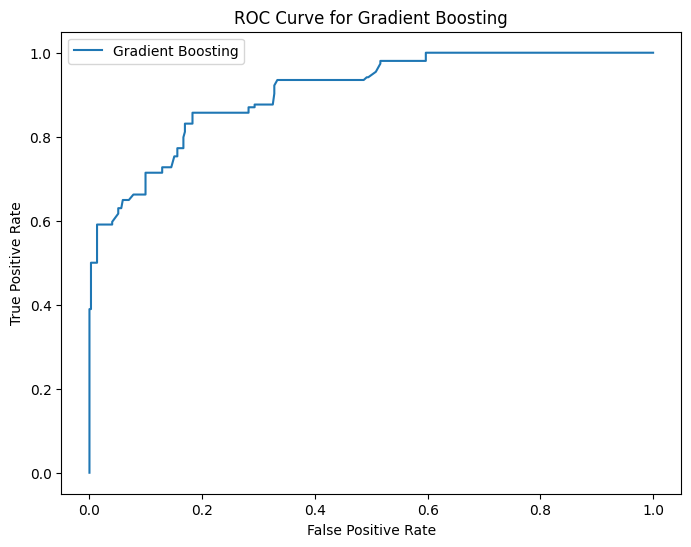

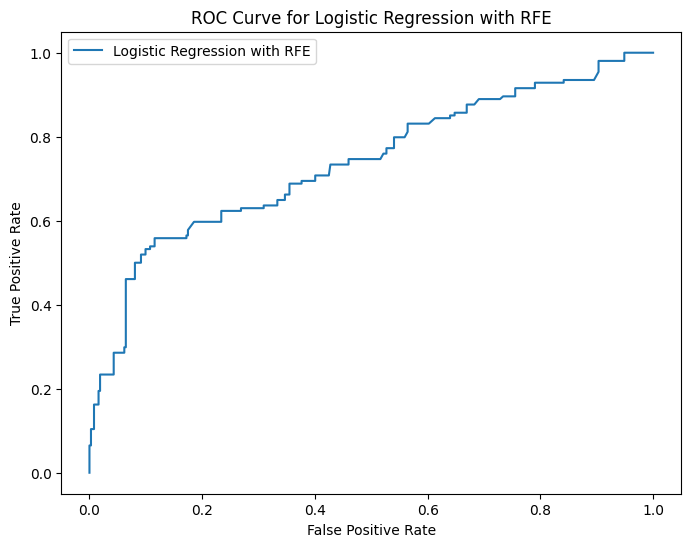

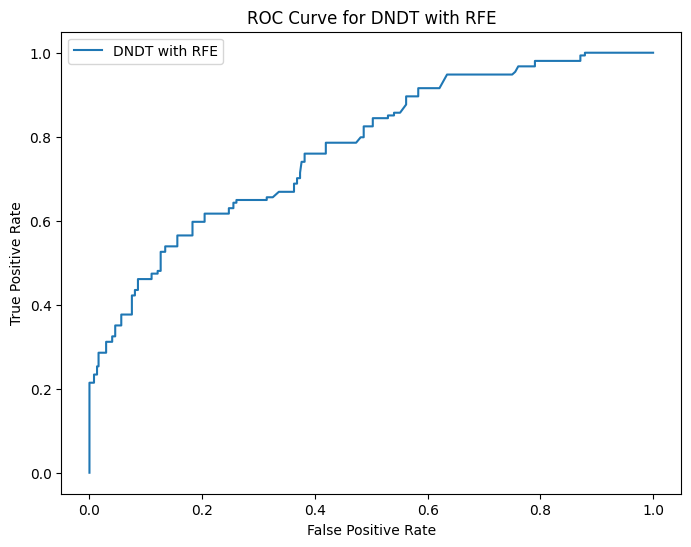

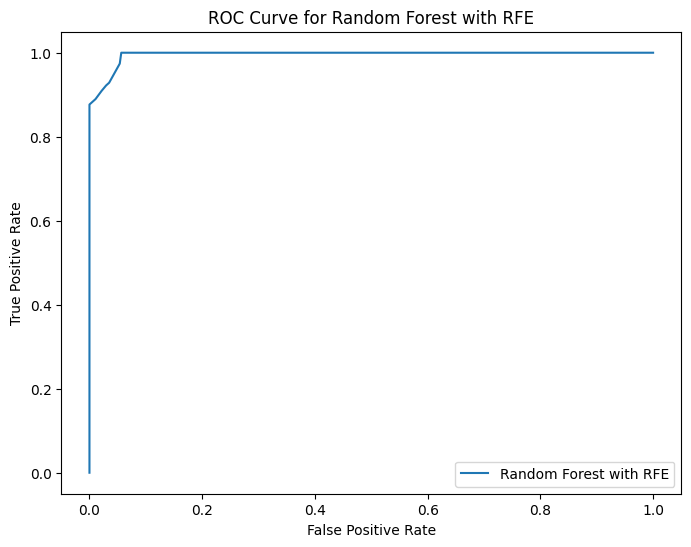

In [314]:
# Visualization: ROC Curve for Gradient Boosting
fig, ax = plt.subplots(figsize=(8, 6))
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_model.predict_proba(X_test)[:, 1])
ax.plot(gb_fpr, gb_tpr, label='Gradient Boosting')
ax.set_title('ROC Curve for Gradient Boosting')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
plt.show()

# Visualization: ROC Curve for Logistic Regression with RFE
fig, ax = plt.subplots(figsize=(8, 6))
lr_fpr, lr_tpr, _ = roc_curve(y_test_lr_rfe, lr_model_rfe.predict_proba(X_test_lr_rfe)[:, 1])
ax.plot(lr_fpr, lr_tpr, label='Logistic Regression with RFE')
ax.set_title('ROC Curve for Logistic Regression with RFE')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
plt.show()

# Visualization: ROC Curve for DNDT with RFE
fig, ax = plt.subplots(figsize=(8, 6))
dndt_proba = dndt_model_rfe(X_test_tensor_rfe).detach().numpy()[:, 1]
dndt_fpr, dndt_tpr, _ = roc_curve(y_test_tensor_rfe.numpy(), dndt_proba)
ax.plot(dndt_fpr, dndt_tpr, label='DNDT with RFE')
ax.set_title('ROC Curve for DNDT with RFE')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
plt.show()

# Visualization: ROC Curve for Random Forest with RFE
fig, ax = plt.subplots(figsize=(8, 6))
rf_fpr, rf_tpr, _ = roc_curve(y_test_rf_rfe, rf_model_rfe.predict_proba(X_test_rf_rfe)[:, 1])
ax.plot(rf_fpr, rf_tpr, label='Random Forest with RFE')
ax.set_title('ROC Curve for Random Forest with RFE')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
plt.show()

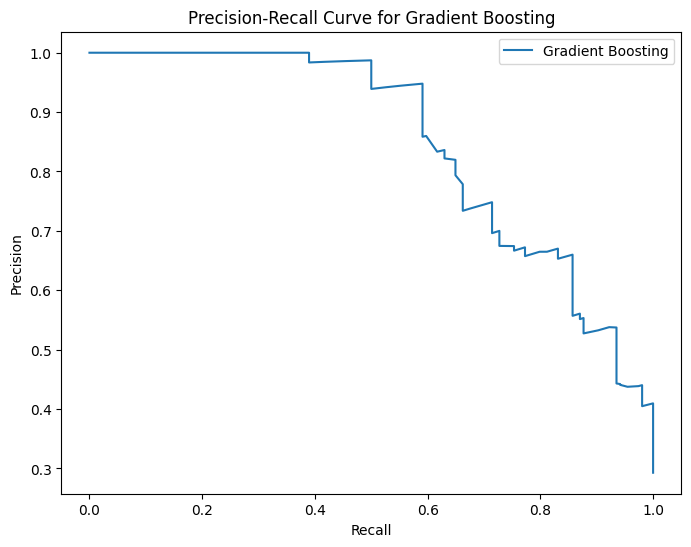

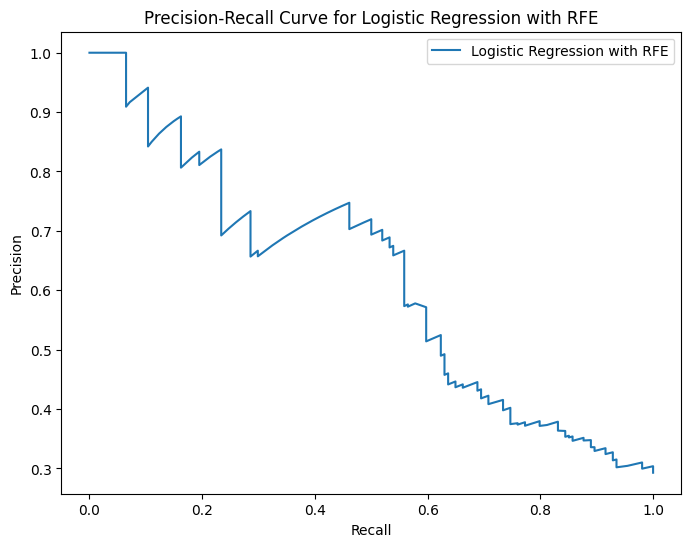

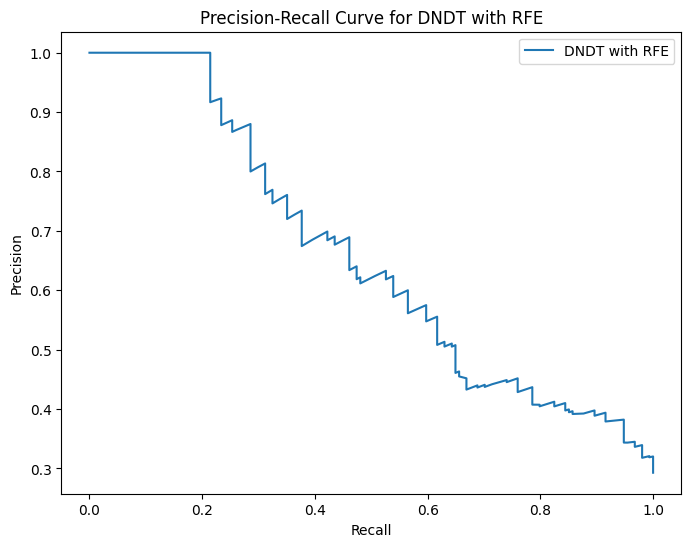

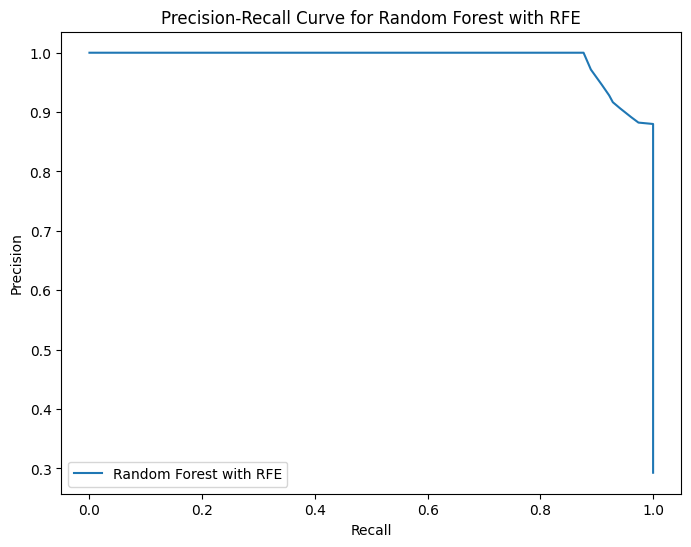

In [315]:
# Visualization: Precision-Recall Curve for Gradient Boosting
fig, ax = plt.subplots(figsize=(8, 6))
gb_precision, gb_recall, _ = precision_recall_curve(y_test, gb_model.predict_proba(X_test)[:, 1])
ax.plot(gb_recall, gb_precision, label='Gradient Boosting')
ax.set_title('Precision-Recall Curve for Gradient Boosting')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()
plt.show()

# Visualization: Precision-Recall Curve for Logistic Regression with RFE
fig, ax = plt.subplots(figsize=(8, 6))
lr_precision, lr_recall, lr_thresholds = precision_recall_curve(y_test_lr_rfe, lr_model_rfe.predict_proba(X_test_lr_rfe)[:, 1])
ax.plot(lr_recall, lr_precision, label='Logistic Regression with RFE')
ax.set_title('Precision-Recall Curve for Logistic Regression with RFE')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()
plt.show()

# Visualization: Precision-Recall Curve for DNDT with RFE
fig, ax = plt.subplots(figsize=(8, 6))
dndt_proba = dndt_model_rfe(X_test_tensor_rfe).detach().numpy()[:, 1]
dndt_precision, dndt_recall, _ = precision_recall_curve(y_test_tensor_rfe.numpy(), dndt_proba)
ax.plot(dndt_recall, dndt_precision, label='DNDT with RFE')
ax.set_title('Precision-Recall Curve for DNDT with RFE')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()
plt.show()

# Visualization: Precision-Recall Curve for Random Forest with RFE
fig, ax = plt.subplots(figsize=(8, 6))
rf_precision, rf_recall, _ = precision_recall_curve(y_test_rf_rfe, rf_model_rfe.predict_proba(X_test_rf_rfe)[:, 1])
ax.plot(rf_recall, rf_precision, label='Random Forest with RFE')
ax.set_title('Precision-Recall Curve for Random Forest with RFE')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()
plt.show()


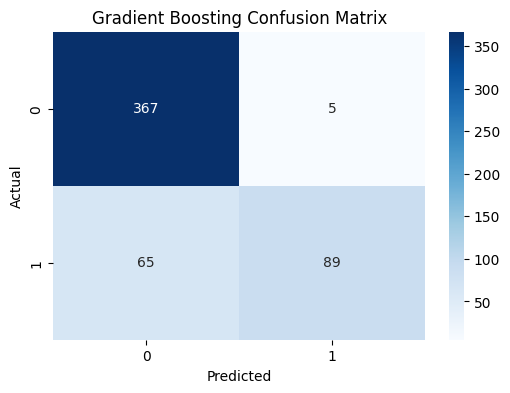

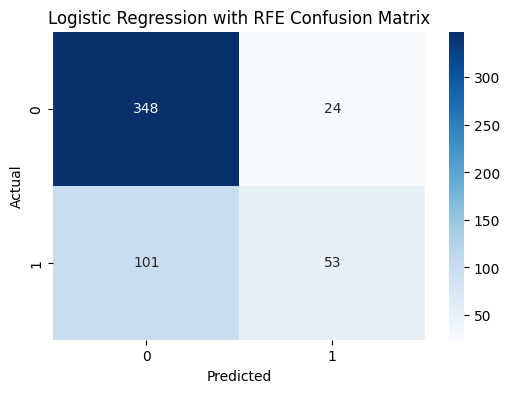

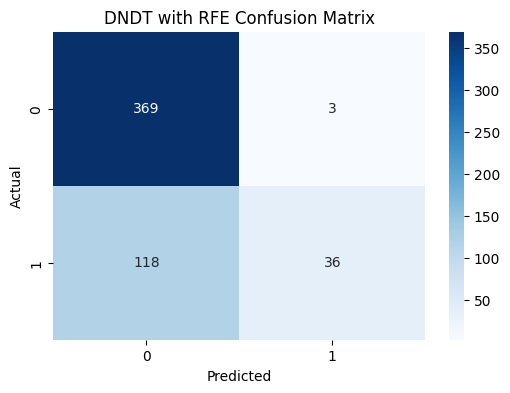

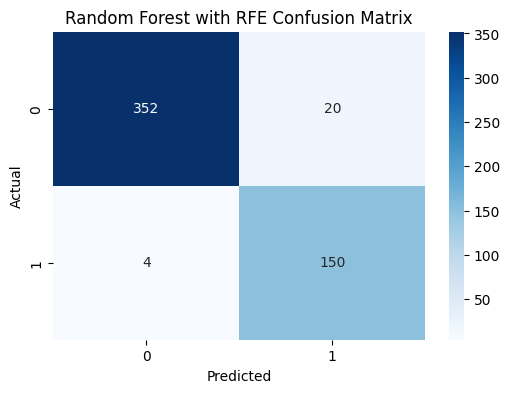

In [316]:
# Confusion Matrix Visualization
def plot_confusion_matrix(cm, title):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.show()

# Confusion Matrix for Gradient Boosting
gb_cm = confusion_matrix(y_test, gb_predictions)
plot_confusion_matrix(gb_cm, 'Gradient Boosting Confusion Matrix')

# Confusion Matrix for Logistic Regression with RFE
lr_cm = confusion_matrix(y_test_lr_rfe, lr_predictions_rfe)
plot_confusion_matrix(lr_cm, 'Logistic Regression with RFE Confusion Matrix')

# Confusion Matrix for DNDT with RFE
dndt_cm = confusion_matrix(y_test_tensor_rfe.numpy(), dndt_predictions_rfe.numpy())
plot_confusion_matrix(dndt_cm, 'DNDT with RFE Confusion Matrix')

# Confusion Matrix for Random Forest with RFE
rf_cm = confusion_matrix(y_test_rf_rfe, rf_predictions_rfe)
plot_confusion_matrix(rf_cm, 'Random Forest with RFE Confusion Matrix')

C:\Users\user\AppData\Local\Temp\ipykernel_6984\4182434639.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance[sorted_idx], y=features, palette='viridis', ax=ax)


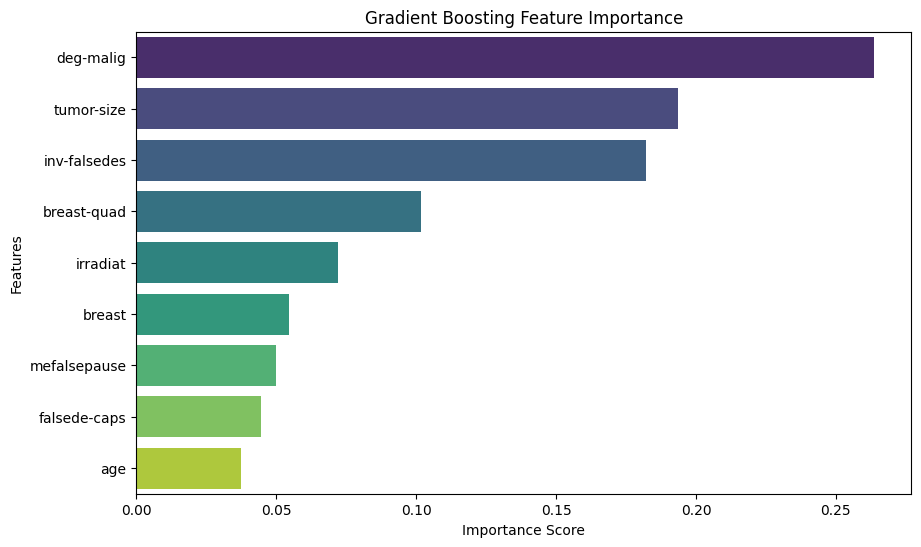

In [317]:
# Feature Importance for Gradient Boosting
feature_importance = gb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
features = data.drop('class', axis=1).columns[sorted_idx]

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=feature_importance[sorted_idx], y=features, palette='viridis', ax=ax)
ax.set_title('Gradient Boosting Feature Importance')
ax.set_xlabel('Importance Score')
ax.set_ylabel('Features')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_6984\4144306143.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lr_coefficients[sorted_idx_lr], y=features_lr, palette='viridis', ax=ax)


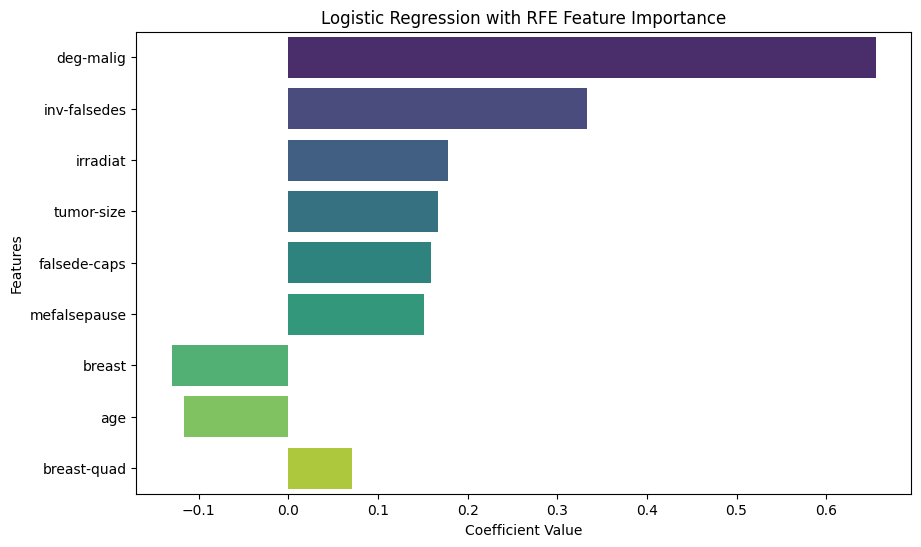

In [318]:
# Feature Importance for Logistic Regression with RFE
lr_coefficients = lr_model_rfe.coef_[0]  # Logistic Regression coefficients
sorted_idx_lr = np.argsort(np.abs(lr_coefficients))[::-1]

features_lr = data.drop('class', axis=1).columns[sorted_idx_lr]

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=lr_coefficients[sorted_idx_lr], y=features_lr, palette='viridis', ax=ax)
ax.set_title('Logistic Regression with RFE Feature Importance')
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Features')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_6984\3332535547.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dndt_importances[sorted_idx_dndt], y=features_dndt, palette='viridis', ax=ax)


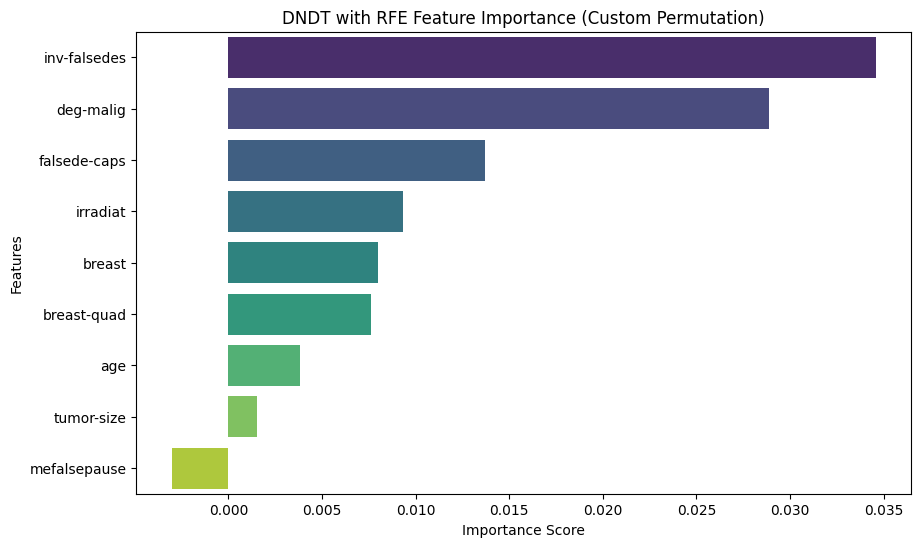

In [319]:
def custom_permutation_importance(model, X, y, n_repeats=10, random_state=42):
    np.random.seed(random_state)
    baseline_accuracy = accuracy_score(y, model(X).argmax(axis=1))
    importances = np.zeros(X.shape[1])
    
    for i in range(X.shape[1]):
        permuted_accuracies = np.zeros(n_repeats)
        for n in range(n_repeats):
            X_permuted = X.clone().detach()  # Clone the tensor to avoid in-place modification
            X_permuted[:, i] = X_permuted[torch.randperm(X.size(0)), i]  # Permute the feature column
            permuted_accuracies[n] = accuracy_score(y, model(X_permuted).argmax(axis=1))
        importances[i] = baseline_accuracy - np.mean(permuted_accuracies)
    
    return importances

# Convert X_test to a tensor for DNDT model
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Calculate permutation importance for DNDT model with RFE
dndt_importances = custom_permutation_importance(dndt_model_rfe, X_test_tensor_rfe, y_test_tensor_rfe.numpy())

# Sort and plot the results
sorted_idx_dndt = np.argsort(dndt_importances)[::-1]
features_dndt = data.drop('class', axis=1).columns[sorted_idx_dndt]

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=dndt_importances[sorted_idx_dndt], y=features_dndt, palette='viridis', ax=ax)
ax.set_title('DNDT with RFE Feature Importance (Custom Permutation)')
ax.set_xlabel('Importance Score')
ax.set_ylabel('Features')
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_6984\3865421632.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_feature_importance[sorted_idx_rf], y=features_rf, palette='viridis', ax=ax)


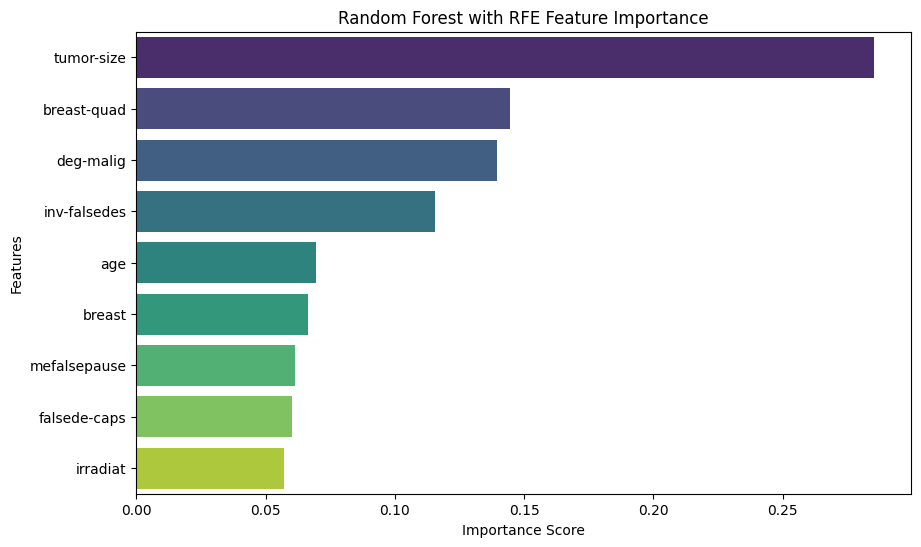

In [320]:
# Feature Importance for Random Forest with RFE
rf_feature_importance = rf_model_rfe.feature_importances_
sorted_idx_rf = np.argsort(rf_feature_importance)[::-1]

features_rf = data.drop('class', axis=1).columns[sorted_idx_rf]

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=rf_feature_importance[sorted_idx_rf], y=features_rf, palette='viridis', ax=ax)
ax.set_title('Random Forest with RFE Feature Importance')
ax.set_xlabel('Importance Score')
ax.set_ylabel('Features')
plt.show()

In [321]:
# # Ensure Precision and Recall are single values
# gb_precision = np.mean(gb_precision) if isinstance(gb_precision, (list, np.ndarray)) else gb_precision
# lr_precision_rfe = np.mean(lr_precision_rfe) if isinstance(lr_precision_rfe, (list, np.ndarray)) else lr_precision_rfe
# dndt_precision_rfe = np.mean(dndt_precision_rfe) if isinstance(dndt_precision_rfe, (list, np.ndarray)) else dndt_precision_rfe
# rf_precision_rfe = np.mean(rf_precision_rfe) if isinstance(rf_precision_rfe, (list, np.ndarray)) else rf_precision_rfe

# # Create DataFrame with model performance metrics
# data = {
#     'Model': ['Gradient Boosting', 'Logistic Regression', 'DNDT', 'Random Forest'],
#     'Accuracy': [gb_accuracy * 100, lr_accuracy_rfe * 100, dndt_accuracy_rfe * 100, rf_accuracy_rfe * 100],
#     'ROC-AUC': [gb_roc_auc, lr_roc_auc_rfe, dndt_roc_auc_rfe, rf_roc_auc_rfe],
#     'Precision': [gb_precision, lr_precision_rfe, dndt_precision_rfe, rf_precision_rfe],
#     'Recall': [gb_recall, lr_recall_rfe, dndt_recall_rfe, rf_recall_rfe]
# }

# # Convert any lists in Precision and Recall to their mean
# for i in range(len(data['Model'])):
#     data['Precision'][i] = np.mean(data['Precision'][i]) if isinstance(data['Precision'][i], (list, np.ndarray)) else data['Precision'][i]
#     data['Recall'][i] = np.mean(data['Recall'][i]) if isinstance(data['Recall'][i], (list, np.ndarray)) else data['Recall'][i]

# # Create DataFrame
# df = pd.DataFrame(data)

# # Display the comparison table
# print("Model Performance Comparison Table:")
# print(df.to_string(index=False))


In [322]:
# Ensure Precision and Recall are directly assigned from the classification report
classification_report_dict = classification_report(y_test, gb_predictions, output_dict=True)
gb_precision = classification_report_dict['weighted avg']['precision']
gb_recall = classification_report_dict['weighted avg']['recall']

# Create DataFrame with model performance metrics
data = {
    'Model': ['Gradient Boosting', 'Logistic Regression', 'DNDT', 'Random Forest'],
    'Accuracy': [gb_accuracy * 100, lr_accuracy_rfe * 100, dndt_accuracy_rfe * 100, rf_accuracy_rfe * 100],
    'ROC-AUC': [gb_roc_auc, lr_roc_auc_rfe, dndt_roc_auc_rfe, rf_roc_auc_rfe],
    'Precision': [gb_precision, lr_precision_rfe, dndt_precision_rfe, rf_precision_rfe],
    'Recall': [gb_recall, lr_recall_rfe, dndt_recall_rfe, rf_recall_rfe]
}

# Directly create the DataFrame
df = pd.DataFrame(data)

# Display the comparison table
print("Model Performance Comparison Table:")
print(df.to_string(index=False))


Model Performance Comparison Table:
              Model  Accuracy  ROC-AUC  Precision   Recall
  Gradient Boosting 86.692015 0.906926   0.878016 0.866920
Logistic Regression 76.235741 0.737266   0.688312 0.344156
               DNDT 76.996198 0.774290   0.923077 0.233766
      Random Forest 95.437262 0.995627   0.882353 0.974026


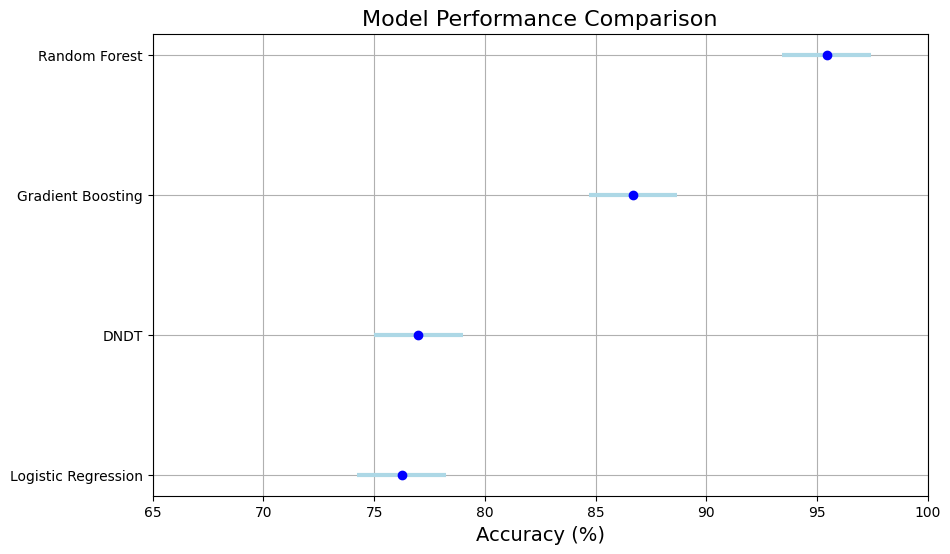

In [323]:
# Sort data by accuracy for better visualization
df_sorted = df.sort_values('Accuracy', ascending=True)

# Define figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot accuracy with error bars (you can replace error bars with actual std deviations if available)
ax.errorbar(df_sorted['Accuracy'], df_sorted['Model'], xerr=2, fmt='o', color='blue', ecolor='lightblue', elinewidth=3, capsize=0)

# Customize the plot
ax.set_title('Model Performance Comparison', fontsize=16)
ax.set_xlabel('Accuracy (%)', fontsize=14)
ax.set_xlim([65, 100])  # Adjust based on your accuracy range
ax.grid(True)

plt.show()

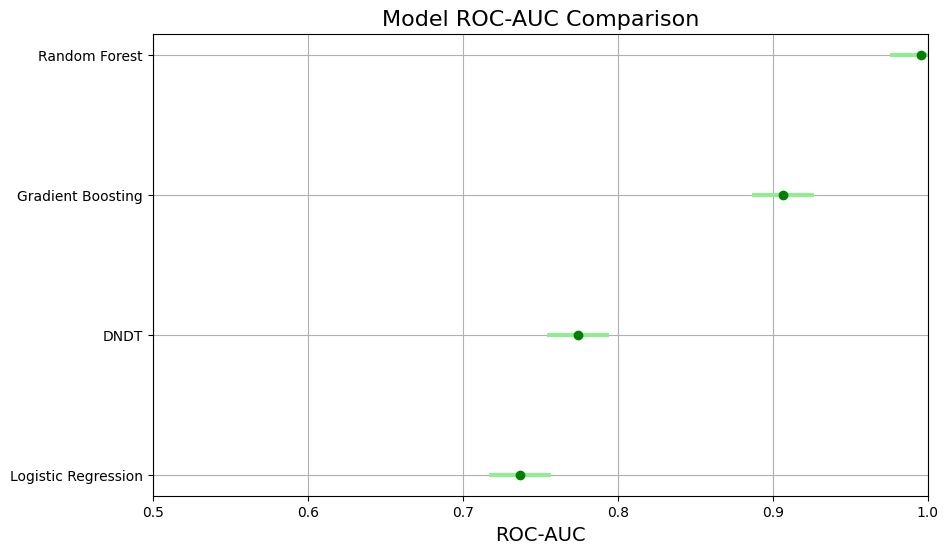

In [324]:
# Sort data by ROC-AUC for better visualization
df_sorted = df.sort_values('ROC-AUC', ascending=True)

# Define figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot ROC-AUC with error bars (you can replace error bars with actual std deviations if available)
ax.errorbar(df_sorted['ROC-AUC'], df_sorted['Model'], xerr=0.02, fmt='o', color='green', ecolor='lightgreen', elinewidth=3, capsize=0)

# Customize the plot
ax.set_title('Model ROC-AUC Comparison', fontsize=16)
ax.set_xlabel('ROC-AUC', fontsize=14)
ax.set_xlim([0.5, 1.0])  # Adjust based on your ROC-AUC range
ax.grid(True)

plt.show()


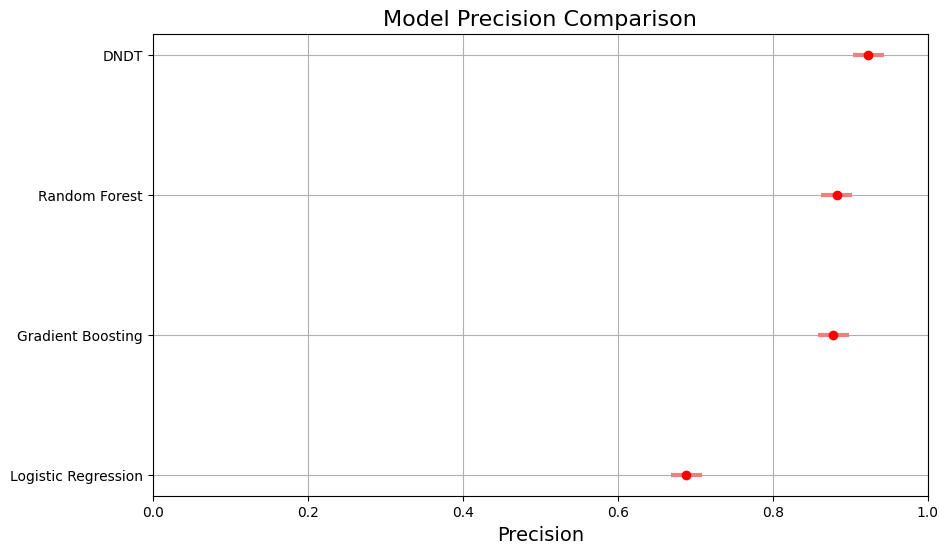

In [325]:
# Sort data by Precision for better visualization
df_sorted = df.sort_values('Precision', ascending=True)

# Define figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Precision with error bars (you can replace error bars with actual std deviations if available)
ax.errorbar(df_sorted['Precision'], df_sorted['Model'], xerr=0.02, fmt='o', color='red', ecolor='lightcoral', elinewidth=3, capsize=0)

# Customize the plot
ax.set_title('Model Precision Comparison', fontsize=16)
ax.set_xlabel('Precision', fontsize=14)
ax.set_xlim([0, 1.0])  # Precision values range between 0 and 1
ax.grid(True)

plt.show()


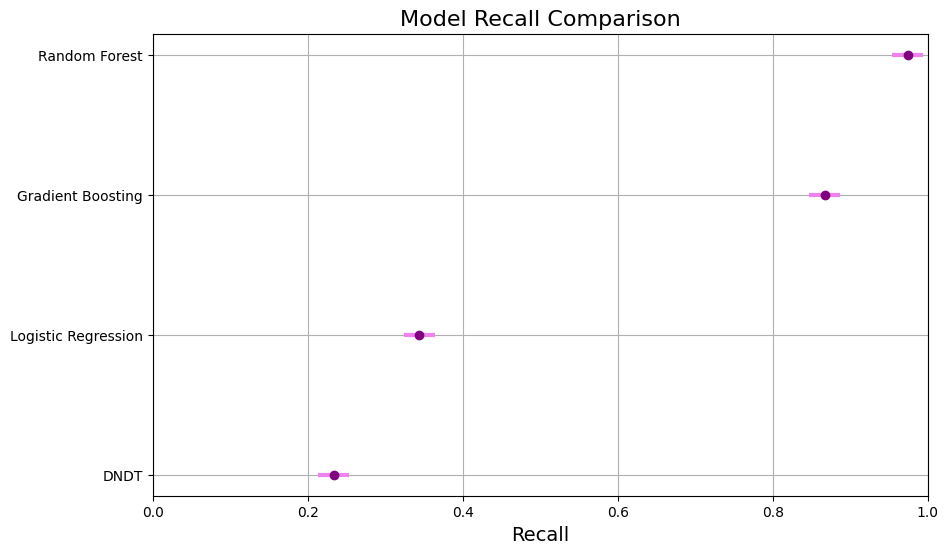

In [326]:
# Sort data by Recall for better visualization
df_sorted = df.sort_values('Recall', ascending=True)

# Define figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Recall with error bars (you can replace error bars with actual std deviations if available)
ax.errorbar(df_sorted['Recall'], df_sorted['Model'], xerr=0.02, fmt='o', color='purple', ecolor='violet', elinewidth=3, capsize=0)

# Customize the plot
ax.set_title('Model Recall Comparison', fontsize=16)
ax.set_xlabel('Recall', fontsize=14)
ax.set_xlim([0, 1.0])  # Recall values range between 0 and 1
ax.grid(True)

plt.show()


In [327]:
import pickle

# Saving Models with Pickle
with open('gradient_boosting_model.pickle', 'wb') as f:
    pickle.dump({'model': gb_model, 'accuracy': gb_accuracy}, f)

with open('LogisticRegression.pickle', 'wb') as f:
    pickle.dump({'model': lr_model_rfe, 'accuracy': lr_accuracy_rfe}, f)

with open('decision_tree_model.pickle', 'wb') as f:
    pickle.dump({'model': dndt_model_rfe, 'accuracy': dndt_accuracy_rfe}, f)

with open('random_forest_model.pickle', 'wb') as f:
    pickle.dump({'model': rf_model_rfe, 'accuracy': rf_accuracy_rfe}, f)